# Part I: Preprocessing and Visualization

## Content:
1. Basic setting and load data
2. Check basic stats
3. Fill missing values
4. Correct outliers

## 1. Basic setting and load data

In [1]:
from typing import Dict, List, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.options.display.max_columns = 20
pd.options.display.max_rows = 20

In [2]:
# Load data
df_sales2016 = pd.read_csv(
    "../data/preprocessed-data/2016_sales.csv", parse_dates=["date"]
)
df_sales2017 = pd.read_csv(
    "../data/preprocessed-data/2017_sales.csv", parse_dates=["date"]
)

In [3]:
# concat 2016 and 2017 sales data
df_sales = pd.concat([df_sales2016, df_sales2017], ignore_index=True)

## 2. Check basic stats

In [4]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365500 entries, 0 to 365499
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    365500 non-null  datetime64[ns]
 1   store   365500 non-null  int64         
 2   item    365500 non-null  int64         
 3   sales   362302 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 11.2 MB


In [55]:
# unique stores and items
lst_stores = df_sales["store"].unique().tolist()
lst_items = df_sales["item"].unique().tolist()
target = lst_stores
print(f"Stores: {target}")
print(f"Num stores: {len(target)}")

Stores: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Num stores: 10


In [90]:
df_sales.describe(include="all", datetime_is_numeric=True)

,date,store,item,sales
count,365500,365500.000000,365500.000000,362302.000000
mean,2016-12-31 00:00:00.000000512,5.500000,25.500000,59.142340
min,2016-01-01 00:00:00,1.000000,1.000000,2.000000
25%,2016-07-01 00:00:00,3.000000,13.000000,33.000000
50%,2016-12-31 00:00:00,5.500000,25.500000,53.000000
75%,2017-07-02 00:00:00,8.000000,38.000000,77.000000
max,2017-12-31 00:00:00,10.000000,50.000000,920.000000
std,NaN,2.872285,14.430889,37.860788


In [97]:
gp_keys = ["store"]
df_basic_stas = df_sales.groupby(gp_keys).agg(
    mean_sales=("sales", "mean"),
    max_sales=("sales", "max"),
    min_sales=("sales", "min"),
)
df_basic_stas.iloc[:].style.background_gradient(cmap="coolwarm")

,mean_sales,max_sales,min_sales
store,,,
1,53.604455,655.000000,3.000000
2,75.722677,855.000000,6.000000
3,67.505756,800.000000,6.000000
4,62.078101,820.000000,5.000000
5,45.175634,595.000000,2.000000
6,44.906920,625.000000,3.000000
7,41.073033,560.000000,2.000000
8,72.476848,920.000000,6.000000
9,62.385562,665.000000,4.000000


In [98]:
# The best and worst
display(df_basic_stas.nlargest(1, "mean_sales"))
display(df_basic_stas.nsmallest(1, "mean_sales"))

,mean_sales,max_sales,min_sales
store,,,
2,75.722677,855.0,6.0


,mean_sales,max_sales,min_sales
store,,,
7,41.073033,560.0,2.0


In [122]:
def get_sample_stores(df: pd.DataFrame, store_id: int = 1) -> pd.DataFrame:
    """Get the sample stores with store_id"""
    grouped = df.groupby("store")
    sample_store = grouped.get_group((store_id))
    return sample_store

In [100]:
df_store2 = get_sample_stores(df_sales, store_id=2)
df_store2.describe()

,store,item,sales
count,36550.0,36550.000000,36243.000000
mean,2.0,25.500000,75.722677
std,0.0,14.431067,44.044088
min,2.0,1.000000,6.000000
25%,2.0,13.000000,44.000000
50%,2.0,25.500000,70.000000
75%,2.0,38.000000,100.000000
max,2.0,50.000000,855.000000


## 3. Check and fill missing values

In [130]:
def check_missing_values(df):
    df_nan = pd.DataFrame(
        {
            "counts": df.isna().sum(),
            "ratio (%)": np.round(df.isna().sum() / df.shape[0], 4) * 100,
        }
    )
    return df_nan

In [102]:
check_missing_values(df_sales)

,counts,ratio (%)
date,0,0.00
store,0,0.00
item,0,0.00
sales,3198,0.87


In [115]:
check_missing_values(df_store2)

,counts,ratio (%)
date,0,0.00
store,0,0.00
item,0,0.00
sales,307,0.87


In [114]:
mask_nan = df_store2.sales.isna()
df_store2.loc[mask_nan, :].iloc[:10]

,date,store,item,sales
461,2016-04-05,2,1,NaN
658,2016-10-19,2,1,NaN
671,2016-11-01,2,1,NaN
4069,2016-02-13,2,2,NaN
4092,2016-03-07,2,2,NaN
7718,2016-02-02,2,3,NaN
7948,2016-09-19,2,3,NaN
7980,2016-10-21,2,3,NaN
7984,2016-10-25,2,3,NaN
15061,2016-02-25,2,5,NaN


In [136]:
def plot_sales(df, store_id=1, item_id=1):
    df_2plot = df.query("(store==@store_id)&(item==@item_id)")

    fig, ax = plt.subplots(figsize=(6, 3))
    df_2plot[["date", "sales"]].plot(x="date", y="sales", ax=ax, legend=False)

    # Replace NaN values with the mean of surrounding two points
    nan_indices = df_2plot[df_2plot["sales"].isna()].index

    if len(nan_indices) >= 1:
        df_2plot = df_2plot.assign(sales=lambda df: df["sales"].fillna(method="ffill"))
        # Draw arrows for NaN values
        nan_dates = df_2plot.loc[nan_indices, "date"]
        nan_sales = df_2plot.loc[nan_indices, "sales"]
        for date, sales in zip(nan_dates, nan_sales):
            ax.annotate(
                "-",
                xy=(date, sales),
                color="red",  # Set text color to red
                size=20,
            )

    # Set plot labels and legend
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.set_title(f"Store {store_id}, Item {item_id}")
    ax.legend()
    plt.show()

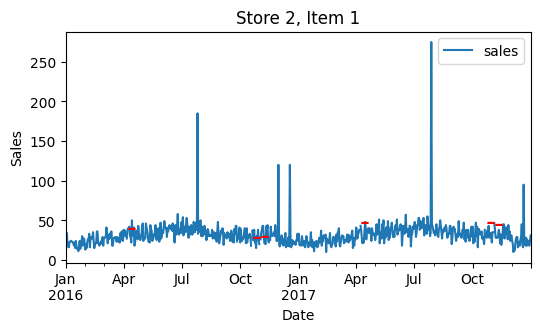

In [138]:
store_id = 2
item_id = 1
df_2plot = df_sales.query("(store==@store_id)&(item==@item_id)")

fig, ax = plt.subplots(figsize=(6, 3))
df_2plot[["date", "sales"]].plot(x="date", y="sales", ax=ax, legend=False)

# Replace NaN values with the mean of surrounding two points
nan_indices = df_2plot[df_2plot["sales"].isna()].index

if len(nan_indices) >= 1:
    df_2plot = df_2plot.assign(sales=lambda df: df["sales"].fillna(method="ffill"))
    # Draw arrows for NaN values
    nan_dates = df_2plot.loc[nan_indices, "date"]
    nan_sales = df_2plot.loc[nan_indices, "sales"]
    for date, sales in zip(nan_dates, nan_sales):
        ax.annotate(
            "-",
            xy=(date, sales),
            color="red",  # Set text color to red
            size=20,
        )

# Set plot labels and legend
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_title(f"Store {store_id}, Item {item_id}")
ax.legend()
plt.show()

In [123]:
def fill_misisng_values(df):
    """Fill NaN values in the 'sales' column with the mean of non-NaN values"""
    df_filled = df.copy()
    df_filled["sales"] = df_filled["sales"].fillna(df_filled["sales"].mean())
    return df_filled

In [131]:
check_missing_values(fill_misisng_values(df_store2))

,counts,ratio (%)
date,0,0.0
store,0,0.0
item,0,0.0
sales,0,0.0


In [133]:
df_sales_filled = fill_misisng_values(df_sales)

In [134]:
check_missing_values(df_sales_filled)

,counts,ratio (%)
date,0,0.0
store,0,0.0
item,0,0.0
sales,0,0.0


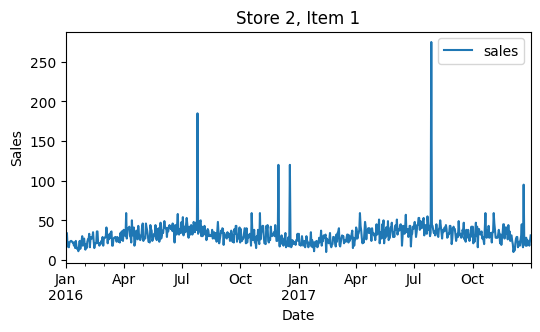

In [137]:
plot_sales(df_sales_filled, store_id=2, item_id=1)

## 4. Check and correct outliers

In [163]:
(
    df_sales.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999])
    .iloc[1:,]
    .style.background_gradient(cmap="coolwarm")
)

,store,item,sales
mean,5.500000,25.500000,59.142340
std,2.872285,14.430889,37.860788
min,1.000000,1.000000,2.000000
10%,1.900000,5.900000,22.000000
25%,3.000000,13.000000,33.000000
50%,5.500000,25.500000,53.000000
75%,8.000000,38.000000,77.000000
90%,9.100000,45.100000,103.000000
99%,10.000000,50.000000,153.000000
99.9%,10.000000,50.000000,450.000000


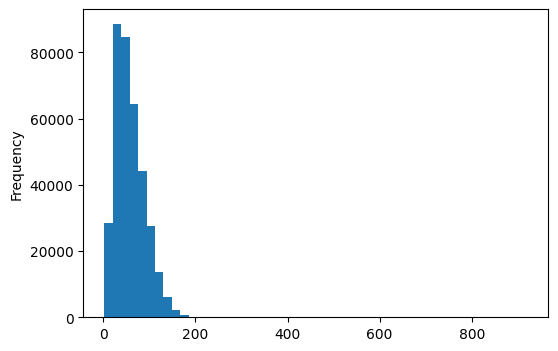

In [161]:
fig, ax = plt.subplots(figsize=(6, 4))
df_sales["sales"].plot(kind="hist", bins=50, ax=ax);

In [166]:
threshold_sales = 450
df_store2.query("sales >= @threshold_sales")

,date,store,item,sales
18812,2016-05-26,2,6,465.0
26252,2016-09-23,2,8,595.0
33495,2016-07-08,2,10,650.0
37192,2016-08-14,2,11,660.0
44422,2016-05-16,2,13,535.0
...,...,...,...,...
336847,2017-07-02,2,43,600.0
336938,2017-10-01,2,43,540.0
344044,2017-03-21,2,45,510.0
344105,2017-05-21,2,45,770.0


In [169]:
def correct_outliers(df, factor=3):
    """Identify and correct outliers in the 'sales' column by reducing them to the mean"""
    df_corrected = df.copy()

    # Identify outliers using z-score
    z_scores = (df_corrected["sales"] - df_corrected["sales"].mean()) / df_corrected[
        "sales"
    ].std()
    outlier_indices = np.abs(z_scores) > factor  # Adjust the threshold as needed
    # Correct outliers by reducing them to the mean
    df_corrected.loc[outlier_indices, "sales"] = df_corrected["sales"].mean()

    return df_corrected

In [170]:
# Correct outliers
df_sales_corrected = correct_outliers(df=df_sales_filled)

In [172]:
(
    df_sales_corrected.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999])
    .iloc[1:,]
    .style.background_gradient(cmap="coolwarm")
)

,store,item,sales
mean,5.500000,25.500000,57.716179
std,2.872285,14.430889,30.674866
min,1.000000,1.000000,2.000000
10%,1.900000,5.900000,22.000000
25%,3.000000,13.000000,33.000000
50%,5.500000,25.500000,53.000000
75%,8.000000,38.000000,76.000000
90%,9.100000,45.100000,101.000000
99%,10.000000,50.000000,143.000000
99.9%,10.000000,50.000000,165.000000


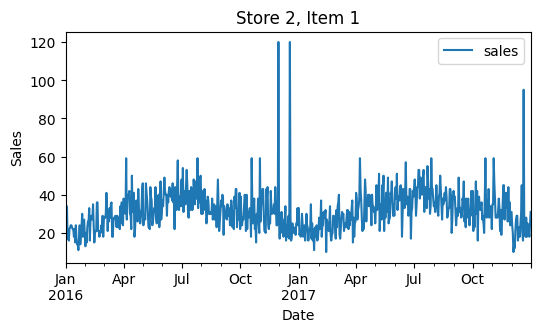

In [173]:
plot_sales(df_sales_corrected, store_id=2, item_id=1)

## 5. Visualization all stores and items

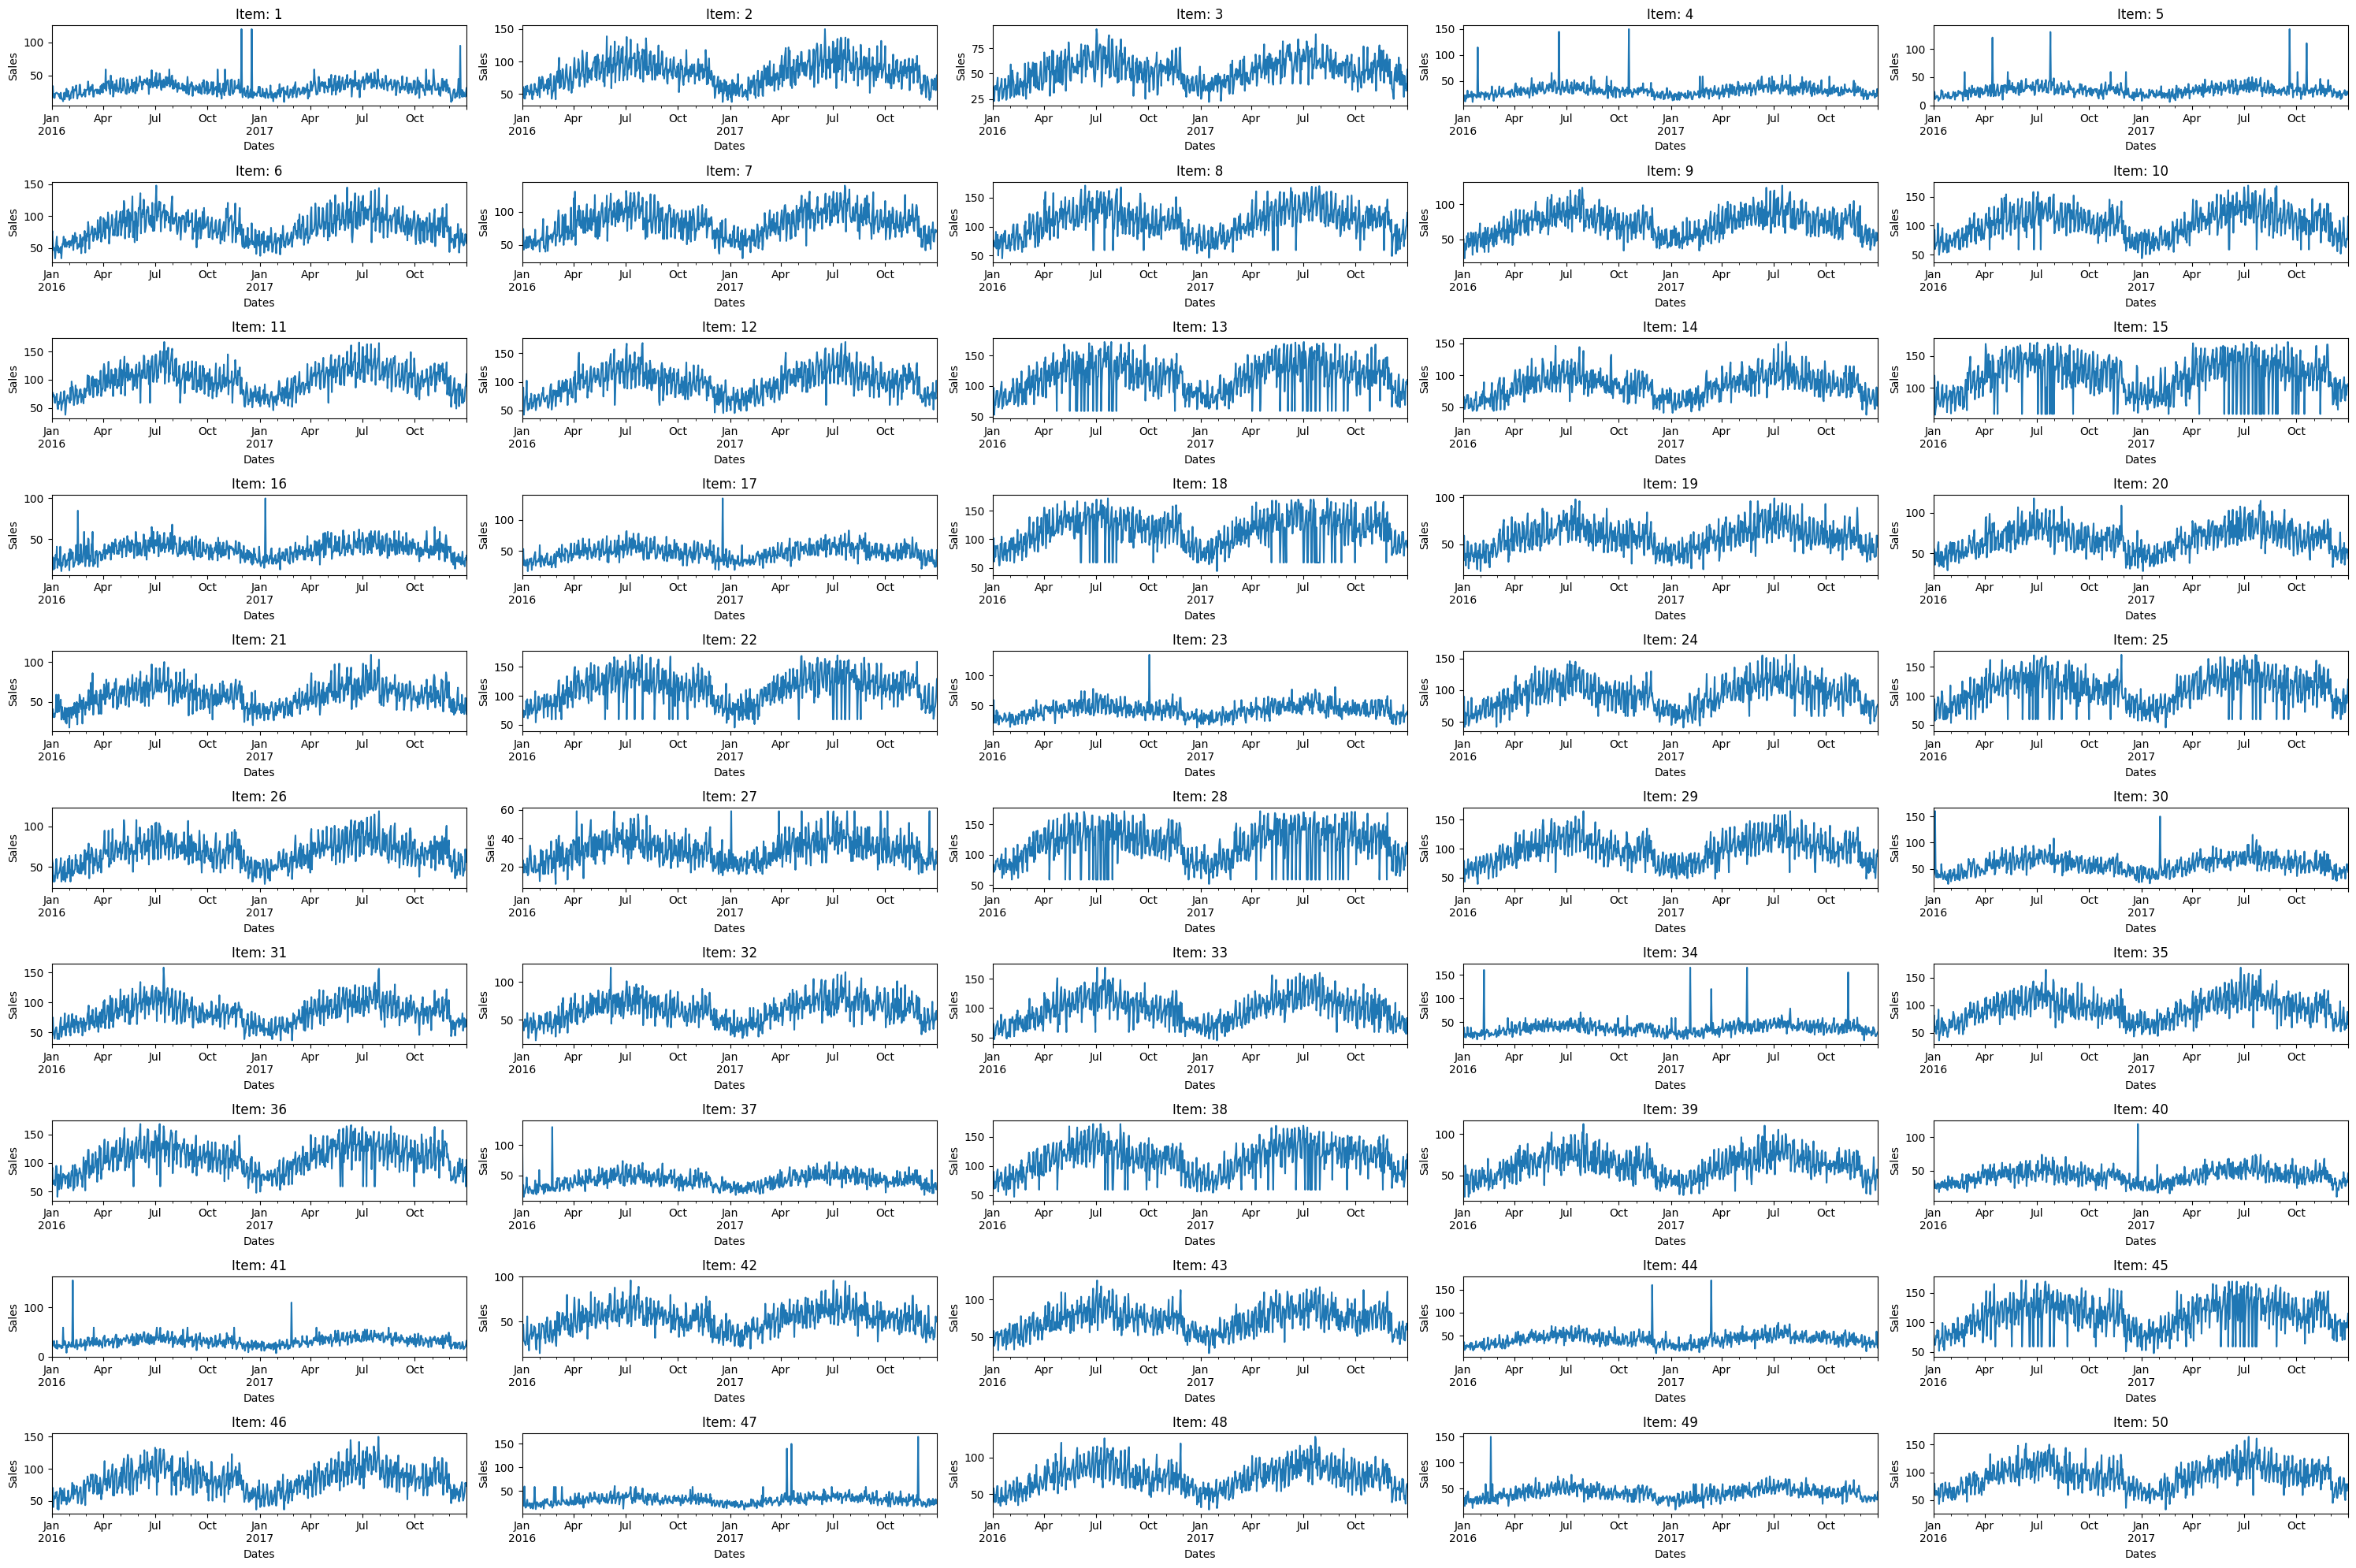

In [189]:
# get targeted store
store_id = 2
df_sample_store = get_sample_stores(df_sales_corrected, store_id=2)

# visualization
nrows = 10
ncols = 5
fig, axes = plt.subplots(nrows, ncols, figsize=(nrows * 3, ncols * 4))
# fig.suptitle(f"Sales Trend - Store: {store_id}")

for item_id, ax in zip(lst_items, axes.flat):
    df2plot = df_sample_store.query("item==@item_id")
    df2plot[["date", "sales"]].plot(x="date", y="sales", ax=ax)
    ax.legend().remove()
    ax.set_xlabel("Dates")
    ax.set_ylabel("Sales")
    ax.set_title(f"Item: {item_id}")

fig.tight_layout()

## Save preprocessed data

In [174]:
output_path = "../data/preprocessed-data/sales_data_preprocessed.csv"
df_sales_corrected.to_csv(output_path, index=False)